
Imports

In [2]:
import os

from sklearn.cluster import HDBSCAN
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from langchain_core.messages import SystemMessage
from langchain_core.prompts import (
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    ChatPromptTemplate
)

# Import Azure OpenAI
from langchain_openai import AzureOpenAIEmbeddings
from langchain_openai import AzureChatOpenAI

from dotenv import load_dotenv

from collections import Counter

%load_ext autoreload
%autoreload 2

Load environment variables

In [3]:
# Construct an absolute path to where your .env file is located
dotenv_path = os.path.join(os.getcwd(), '.env')
result = load_dotenv(dotenv_path)
print(result)  # This should print True if the file is loaded successfully

True


Prepare deployed Azure OpenAI models

[Deployed models in Azure Portal](https://oai.azure.com/portal/fdd568fbdff34acfbd92a47db2fa9f36/deployment?tenantid=e23925be-c276-4284-897f-ca99bfbeed44)


In [4]:

embeddings_client = AzureOpenAIEmbeddings(
    azure_deployment="text-embedding-3-small-eastus",
    openai_api_version="2024-02-01",
)

llm_client = AzureChatOpenAI(
    openai_api_version="2024-02-01",
    azure_deployment="gpt-35-turbo-16k",
)

# News

## Get news article from NewsApiClient

In [ ]:
newsapi = NewsApiClient(api_key=os.getenv("NEWSAPI_API_KEY"))

sources_1 = [
    "the-washington-post",
]
sources_2 = [
    "the-wall-street-journal",
]
sources_3 = [
    "business-insider",
]
sources_4 = [
    "associated-press",
]
sources_5 = [
    "bloomberg",
]

recent_articles = []

for source in [sources_1, sources_2,sources_3, sources_4,sources_5]:
    recent_articles.extend(newsapi.get_everything(
        sources=",".join(source),
        language="en",
        page_size=100,
    )["articles"])

In [ ]:
print(len(recent_articles))

Remove none


In [12]:
recent_articles = [a for a in recent_articles if a["title"] is not None and a["description"] is not None]

NameError: name 'recent_articles' is not defined

In [ ]:
docs = [
    a["title"] + "\n\n" + a["description"]
    for a in recent_articles
]

print(len(docs))

320


In [ ]:
embeddings = embeddings_client.embed_documents(docs)

In [ ]:
print(len(embeddings))
print(len(embeddings[0]))

320
1536


## Clustering News Articles

In [ ]:

df = pd.DataFrame({
    "title": [article["title"] for article in recent_articles],
    "description": [article["description"] for article in recent_articles],
})


### Cluster with k-means

In [ ]:
matrix = np.vstack(embeddings)
matrix.shape

(320, 1536)

In [ ]:
n_clusters = 12

In [ ]:

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

#df.groupby("cluster").mean().sort_values()

### Cluster with hbdscan

In [ ]:
hdb = hdbscan.HDBSCAN(min_samples=3, min_cluster_size=3).fit(embeddings)
labels = hdb.labels_

Add Cluster labels to dataframe

In [ ]:
df["cluster"] = labels

In [ ]:
print("Number of articles within cluster: ", df.query("cluster != -1").shape[0])
print("Number of articles without assigned cluster: ", df.query("cluster == -1").shape[0])

Number of articles within cluster:  115
Number of articles without assigned cluster:  205


Remove documents that are not in a cluster

In [ ]:
#df = df.query("cluster != -1")

Print numbers of cluster entities

In [ ]:
print(df.cluster.value_counts())

cluster
-1     205
 13     22
 9      12
 5      11
 14      9
 2       8
 12      7
 11      6
 7       6
 1       6
 10      5
 15      4
 3       4
 4       4
 8       4
 0       4
 6       3
Name: count, dtype: int64


### t-SNE

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

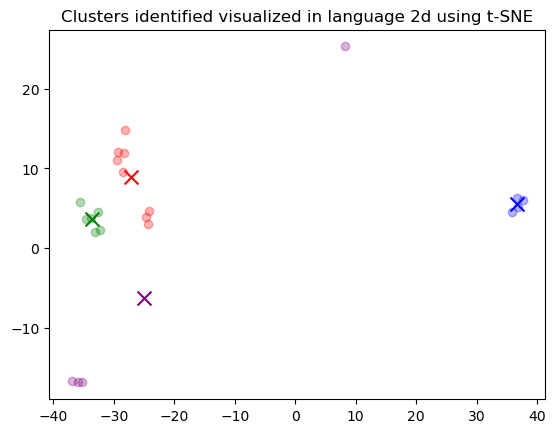

In [ ]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


## Cluster naming with GPT

Prepare prompt

In [ ]:
def get_prompt(articles_str):
    system_message = "You're an expert journalist. You're helping me write a compelling topic title for news articles."
    human_message = f"Using the following articles, write a topic title (2-3 sentences) that summarizes them:\n\n{articles_str}"

    prompt = ChatPromptTemplate(
        messages=[
            SystemMessagePromptTemplate(content=system_message),
            HumanMessagePromptTemplate(content=human_message)
        ]
    )
    return prompt

In [ ]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "You're an expert journalist. You're helping me write a compelling topic title for news articles."
            )
        ),
        HumanMessagePromptTemplate.from_template("Using the following articles, write a topic title (2-3 sentences) that summarizes them.\n\nARTICLES:{articles}\n\nTOPIC TITLE:"),
        
    ]
)

In [ ]:
df = df.query("cluster != 4")

In [ ]:
for c in df.cluster.unique():
    #print(c)
    # Generate articles string
    articles_str = "\n".join(
        f"{article['title']}\n{article['description']}\n"
        for article in df.query(f"cluster == {c}").to_dict(orient="records")
    )
    
    # Create prompt
    #prompt = get_prompt(articles_str)
    prompt = chat_template.format_messages(articles=articles_str)
    # Invoke the model and pass the generated prompt
    result = llm_client.invoke(prompt)
    #print(result)

    # Assuming result extraction based on your specific response structure
    df.loc[df.cluster == c, "topic_title"] = result.content

15
2
3
6
12
1
14
11
9
8
7
0
10
5


In [ ]:
for c in df.cluster.unique():
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c}")
        print(df.query(f"cluster == {c}").topic_title.values[0])
       # display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())
# %%


Cluster 15
"Protests on College Campuses: Clashes, Investigations, and Biden's Response"
Cluster 2
Navigating Friendship Turmoil, Provocative Dressing, and Postnuptial Considerations: Insights from Carolyn Hax's Advice Column
Cluster 3
"Washington Nationals' Offensive Surge, Defensive Resurgence, and Pitching Heroics Propel Team to .500 Record"
Cluster 6
"Tesla's Retreat Raises Concerns for Future of US EV Charging Network, While Chinese Materials Disqualify EVs from Tax Credit"
Cluster 12
"SEC Charges Trump Media's Auditor with Massive Fraud, Bans Accounting Firm"
Cluster 1
"Family-Friendly Dining and Entertainment: Best Restaurants and Shows for Kids in the D.C. Area"
Cluster 14
"The Intriguing Dynamics of the 2024 Electorate: Beyond Biden and Trump"
Cluster 11
Mixed Signals: April Jobs Report and Federal Reserve Debates on Rate Cuts
Cluster 9
"Latest Developments in Abortion Laws: Texas Man's Legal Action and Arizona's Repeal of a 19th Century Ban"
Cluster 8
"Apple's Struggles and t

# TikTok data

## Get test data from csv

In [5]:
path_csv= "data/"

df = pd.read_csv(path_csv+'tiktok_videos_based_on_hashtags_cleaned_transcribed.csv')
# Filter out videos with the same video_id
df = df.drop_duplicates(subset=['video_id'])

print(len(df))

5006


In [6]:
docs_classifier = [
   str(df["video_description"][a]) + "\n\n" +  str(df["suggested_words"][a]) +"\n\n" +  str(df["german_transcript"][a])
    for a in df.index
]

docs = [str(df["german_transcript"][a])
    for a in df.index
]

print(len(docs))

5006


In [9]:
embeddings_classifier = embeddings_client.embed_documents(docs_classifier)
embeddings_classifier=np.array(embeddings_classifier)

In [7]:
#np.save(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy", embeddings_classifier)

embeddings_classifier=np.load(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed_classifier.npy")

In [8]:
#embeddings = embeddings_client.embed_documents(docs)
#embeddings=np.array(embeddings)

#np.save(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed.npy", embeddings)
embeddings = np.load(path_csv+"/clustering/tiktok_videos_based_on_hashtags_cleaned_transcribed.npy")

In [12]:
#np.save(path_csv+"/clustering/transcriptions.npy", embeddings)
print(len(embeddings))
print(len(embeddings[0]))

5006
1536


## Data cleaning

In [9]:
from reclaim_tiktok.classifier.classifier import Classifier

right_classifier = Classifier(classifier_path="data/classifier/")
result= right_classifier.right_wing_classifier_f_embeddings(docs_classifier, embeddings_classifier, embeddings_client)

In [10]:
docs=np.array(docs)
condition=np.logical_and(result=="right", docs!='nan')
docs_clean=docs[condition]
embeddings_clean=embeddings[condition]
df_clean=df[:][condition]

Filter out the trending videos with the same text/audio 
Should have:
- the text
- the cummulative reach
- three videos with most reach

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Assuming df is your DataFrame with columns 'video_id', 'transcript', and 'embedding'
# Example DataFrame

# Calculate cosine similarity between embeddings
similarities = cosine_similarity(embeddings_clean.tolist())

# Keep track of videos to remove
videos_to_remove = set()

# Iterate through the upper triangular part of the similarity matrix
all_similar=[]
for i in range(len(similarities)):
    similar_videos = np.where((similarities[i] > 0.95))[0]
    if len(similar_videos) > 1:
        all_similar.append(list(similar_videos))
        # If there are similar videos, keep the one with the smallest index
        keep_video = min(similar_videos)
        videos_to_remove.update(set(similar_videos) - {keep_video})



In [12]:
videos_to_remove_index=np.array(df_clean.index)[list(videos_to_remove)]
# Remove similar videos
df_clean_double = df_clean[~df_clean.index.isin(videos_to_remove_index)]
embeddings_clean_double=np.delete(embeddings_clean,list(videos_to_remove), axis=0)
docs_clean_double=np.delete(docs_clean,list(videos_to_remove), axis=0)

In [13]:
all_similar_unique_entries = set(map(tuple, all_similar))

# Convert unique entries back to lists
all_similar_unique_entries = sorted([list(entry) for entry in all_similar_unique_entries])

#print(unique_entries)

In [14]:
def merge_lists(lists):
    result = []
    for l in lists:
        new_set = set(l)
        found = False
        for i in range(len(result)):
            if new_set & result[i]:
                result[i] |= new_set
                found = True
                break
        if not found:
            result.append(new_set)
    return [list(s) for s in result]

In [16]:
unique_entries_merged=merge_lists(all_similar_unique_entries)

In [17]:
transcript_list=[np.array(df_clean["german_transcript"])[li_sim[0]] for li_sim in unique_entries_merged]
playcount_list=[ np.array(df_clean["video_playcount"])[li_sim] for li_sim in unique_entries_merged]
playcount_list_sum=[ sum(np.array(df_clean["video_playcount"])[li_sim]) for li_sim in unique_entries_merged]
most_popular_vid=[np.array(df_clean["video_id"])[li_sim] for li_sim in unique_entries_merged]

np.argsort(playcount_list_sum)

array([89, 88, 86, 87, 85, 84, 83, 80, 82, 79, 81, 74, 78, 72, 73, 71, 75,
       76, 66, 69, 77, 68, 67, 70, 64, 62, 63, 65, 61, 60, 57, 58, 56, 52,
       59, 51, 53, 54, 46, 43, 55, 45, 50, 42, 49, 39, 44, 38, 37, 35, 47,
       48, 40, 41, 33, 32, 34, 31, 26, 28, 27, 30, 21, 36, 29, 22, 20, 19,
       16, 23, 17, 18, 14, 25, 12, 13, 15,  9, 10, 24,  7,  8,  6, 11,  5,
        3,  4,  1,  2,  0])

Display three videos which are most popular

In [18]:
for ncount in range(1,4):
    most_popular_narr=np.argsort(playcount_list_sum)[-ncount]
    most_popular_video=np.argmax(playcount_list[most_popular_narr])
    print(str(ncount) +". popular viral audio")
    print(transcript_list[most_popular_narr])
    print(str(playcount_list_sum[most_popular_narr]) +" views")
    print("Example video "+ str(most_popular_vid[most_popular_narr][most_popular_video]) + " with a reach of " + str(playcount_list[most_popular_narr][most_popular_video]))
    print("\n")

1. popular viral audio
falls sie in einem Land leben in dem sie für das Fischen ohne Anglerschein bestraft werden jedoch nicht für den illegalen Grenzübertritt ohne gültigen Reisepass dann haben sie das volle Recht zu sagen dieses Land wird von Idioten regiert 
6123955 views
Example video 7259813032321092891 with a reach of 6056046


2. popular viral audio
Sehr geehrte Frau Präsidentin, sehr geehrter Bundeskanzler, sehr geehrte Damen und Herren, sie haben Aus Deutschland 1 Land gemacht, dass sich Aus der Riege der ernstzunehmenden Nationen verabschiedet und als Industrieland abschafft. Ihre Energiewirtschaft zur migrationspolitik wird vom Rest der Welt nur noch als abschreckendes Beispiel gesehen. Selbst für unseren nominellen Verbündeten sind wir vor allem Geldautomat und Waffenlieferant in 1 Kriegsgebiet, während unsere eigene Armee die Fähigkeit zur landesverteidigung verloren hat. Warum sollten andere auch Respekt haben vor einer Regierung, der man ohne aufbegehren die vitale Infra

## Core messages for transcripts longer than 800

In [121]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, die Kernaussagen aus den Transcripts von TikTokVideos zu ziehen."
            )
        ),
        HumanMessagePromptTemplate.from_template("Ziehe aus dem folgenden deutschen Transkript von einem Tiktok-Videos eine möglichst kurze Beschreibung bestehend aus maximal drei und nur maximal drei kurzen und prägnanten Kernaussagen, ohne Titel, starte direkt mit den Kernaussagen. Maximal 8 Wörter pro Kernaussage: \n\nPOSTS:{posts}\n\nTOPIC TITLE:"),
    ]
)

In [162]:
df_clean_double["core_message"]=pd.Series(dtype='str')

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_1451/4283752254.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"]=pd.Series(dtype='str')


In [ ]:
# produce core message
for ind in range(len(df_clean_double)):
    try:
        sentence=df_clean_double["german_transcript"].iloc[ind]
        if len(sentence)>800:
            print(ind)
            prompt = chat_template.format_messages(posts=sentence)
            result=llm_client.invoke(prompt).content
            df_clean_double["core_message"].iloc[ind] = result
    except Exception as e:
        print(f"Error processing index {ind}: {e}")
        continue

In [179]:
core_message=df_clean_double["core_message"]

In [192]:
df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)

# make the new data to be clustered - separate the stuff with "-/n"
docs_cm= [str(df_clean_double["core_message"][a])
    for a in df_clean_double.index
]
# create a new df with 
# index A sentence 

#generate embeddings for that

/var/folders/gk/v50qv9f143gdz3d7bk3lmgbc0000gp/T/ipykernel_1451/3606266784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean_double["core_message"].fillna(df_clean_double["german_transcript"], inplace=True)


In [295]:
# Cleaning the docs
docs_list = list(docs_cm)  # Convert NumPy array to a list

# Process the list of strings
docs_processed_count = [doc.replace("Kernaussage", "").replace("n:", "").replace("1.", "").replace("2.", "").replace("3.", "").split("\n") for doc in docs_list]
docs_processed_count= [[y for y in x if y not in ['n:', '', ' ']] for x in docs_processed_count]
#docs_processed_count = [[x for item in docs_processed_count] for x in item  if x not in ['n:', '', ' ']]
docs_processed = [x for item in docs_processed_count for x in item]

Create a new df with every line for unique core message

In [381]:
id_list=[]
video_reach=[]
timestamp=[]

for n in range(len(df_clean_double)):
    for k in range(len(docs_processed_count[n])):
        id_list.append(df_clean_double["video_id"].iloc[n])
        video_reach.append(df_clean_double["video_playcount"].iloc[n])
        timestamp.append(df_clean_double["video_timestamp"].iloc[n])

In [ ]:
df_cm=pd.DataFrame(docs_processed, columns=['core_message'])
df_cm["cluster"] = labels
df_cm["video_id"] = id_list
df_cm["video_playcount"] = video_reach
df_cm["video_timestamp"] = timestamp

Generate embeddings per core message

In [21]:
embeddings_cm = embeddings_client.embed_documents(docs_processed)
embeddings_cm=np.array(embeddings_cm)

## Data clustering

### HDBScan

In [363]:
for min_cl in range(2,7):
    hdb = HDBSCAN(min_samples=2, min_cluster_size=min_cl).fit(embeddings_cm)
    print(min_cl,len(Counter(hdb.labels_)), Counter(hdb.labels_))

2 774 Counter({-1: 2649, 771: 17, 678: 15, 372: 10, 543: 10, 680: 9, 623: 9, 590: 8, 368: 8, 458: 8, 419: 8, 392: 7, 759: 7, 681: 7, 475: 7, 649: 7, 168: 7, 522: 7, 620: 7, 745: 7, 593: 6, 250: 6, 736: 6, 688: 6, 166: 6, 293: 6, 675: 6, 696: 6, 292: 6, 511: 5, 510: 5, 567: 5, 577: 5, 530: 5, 167: 5, 31: 5, 421: 5, 769: 5, 322: 5, 207: 5, 617: 5, 690: 5, 698: 5, 666: 5, 425: 5, 615: 5, 465: 5, 272: 5, 699: 5, 544: 5, 438: 5, 363: 5, 542: 5, 711: 5, 401: 5, 611: 5, 524: 5, 598: 4, 355: 4, 488: 4, 328: 4, 564: 4, 525: 4, 732: 4, 659: 4, 629: 4, 221: 4, 502: 4, 579: 4, 582: 4, 706: 4, 85: 4, 343: 4, 94: 4, 431: 4, 494: 4, 707: 4, 456: 4, 692: 4, 686: 4, 15: 4, 128: 4, 88: 4, 409: 4, 704: 4, 747: 4, 497: 4, 546: 4, 451: 4, 605: 4, 136: 4, 402: 4, 467: 4, 684: 4, 610: 4, 348: 4, 622: 4, 319: 4, 206: 4, 587: 4, 761: 4, 709: 4, 702: 4, 285: 4, 535: 4, 693: 4, 619: 4, 378: 4, 596: 4, 9: 4, 588: 4, 244: 4, 436: 4, 188: 4, 551: 4, 216: 4, 553: 4, 613: 4, 645: 4, 381: 4, 718: 4, 131: 4, 4: 4, 261:

KeyboardInterrupt: 

In [258]:
for min_saml in range(2,7):
    hdb = HDBSCAN(min_samples=min_saml, min_cluster_size=3).fit(embeddings_clean)
    print(min_saml,len(Counter(hdb.labels_)), Counter(hdb.labels_))

2 38
3 20
4 19
5 14
6 6


In [257]:
hdb = HDBSCAN(min_samples=5, min_cluster_size=4).fit(embeddings_clean)
print(Counter(hdb.labels_))

Counter({-1: 608, 11: 50, 10: 49, 6: 13, 2: 11, 5: 8, 9: 7, 12: 7, 4: 6, 7: 5, 0: 5, 8: 5, 1: 5, 3: 5})


### Kmeans

In [366]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(20, 60):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embeddings_cm)
    distorsions.append(kmeans.inertia_)

Text(0.5, 1.0, 'Elbow curve')

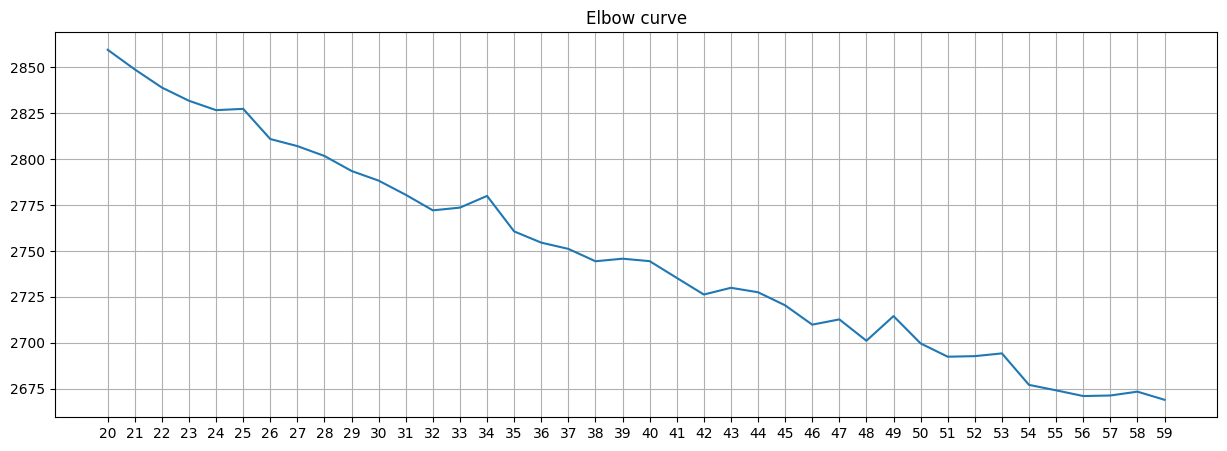

In [367]:
fig = plt.figure(figsize=(15, 5))
plt.plot(range(20, 60), distorsions)
plt.grid(True)
plt.xticks(range(20, 60))
plt.title('Elbow curve')

In [22]:
matrix = np.vstack(embeddings_cm)
matrix.shape

(4735, 1536)

In [23]:
kmeans = KMeans(n_clusters=24, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_

In [432]:
Counter(labels)

Counter({0: 360,
         4: 273,
         14: 273,
         3: 269,
         18: 269,
         20: 243,
         7: 229,
         15: 226,
         2: 224,
         12: 200,
         11: 196,
         23: 195,
         5: 191,
         19: 189,
         1: 179,
         17: 169,
         21: 156,
         16: 154,
         10: 152,
         6: 148,
         13: 136,
         8: 113,
         9: 109,
         22: 82})

### t-SNE Projection of clusters

In [372]:
from sklearn.manifold import TSNE
projection = TSNE().fit_transform(np.array(embeddings_cm))

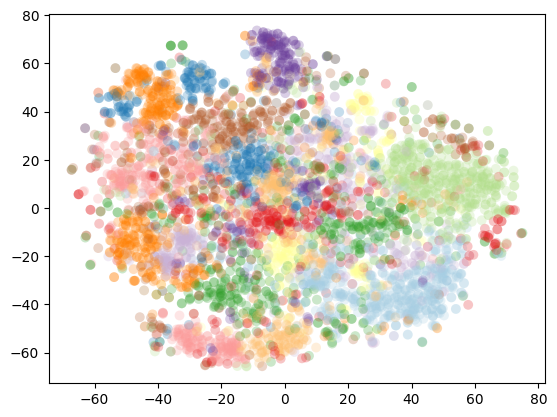

In [436]:
import seaborn as sns

color_palette = sns.color_palette('Paired', len(labels))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in labels]
#cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                         zip(cluster_colors, hdb.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)
#plt.scatter(*projection.T)

### Cluster naming with GPT

In [32]:
chat_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content=(
                "Du bist ein Experte im Schreiben. Du hilfst mir, einen gemeinsamen Titel für mehrere ähnliche TikTok-Beiträge zu schreiben. Der Titel sollte das gemeinsame Narrativ bestmöglichst beschreiben. Beispiele sind: Anti-Einwanderung: Grenzen schließen, nationale Identität schützen. Kritik am Establishment: Gegner des politischen Establishments, Alternativpartei. Kulturelle Identität: Betonung der deutschen Kultur, Traditionen bewahren. Anti-EU: Kritik an der EU, nationale Souveränität betonen. Forderung nach einer harte Hand gegen Kriminalität und Terrorismus. Hetzerischer Angriff und Kritik an Grünen ohne konstruktive Gegenvorschläge."
            )
        ),
        HumanMessagePromptTemplate.from_template("Schreibe anhand der folgenden deutschen Transkripte und Beschreibungen von Tiktok-Videos eine und nur eine möglichst genaue und treffende analytische Beschreibung des Narrativs der Videos: \n\nPOSTS:{posts}\n\nTOPIC TITLE:"),
    ]
)

In [31]:
#try out with stopwords

german_stop_words= open("data/clustering/german_stopwords_full.txt").read().split()[53:]

In [27]:
df_cm[:20]

,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp
0,0,Streik am 08.0 in Deutschland - größter Streik...,14,7320578484609256736,6522042,Protestbewegungen und politische Unzufriedenhe...,1704455008
1,1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",21,7320578484609256736,6522042,Bauernproteste: Wut gegen die Bundesregierung ...,1704455008
2,2,- Unzufriedenheit mit politischer Lage und Geh...,22,7320578484609256736,6522042,Unzufriedenheit mit der politischen Situation ...,1704455008
3,3,falls sie in einem Land leben in dem sie für d...,3,7259813032321092891,6056046,Die schleichende Zerstörung Deutschlands: Krit...,1690306946
4,4,- Bürgergeld oder Grundeinkommen? Keins von be...,13,7317232563129552161,5817725,"Rentenproblematik in Deutschland: Altersarmut,...",1703675984
5,5,- Angst vor Sarah Wagenknecht? Linke sollte An...,8,7317232563129552161,5817725,"""Kritik am politischen Establishment und Forde...",1703675984
6,6,- Bürgergeld nicht für ausländische Staatsbürger,3,7317232563129552161,5817725,Forderung nach einer restriktiven Einwanderung...,1703675984
7,7,wer sind sie eigentlich? hab sie noch nie gese...,2,7325036849943022881,4858904,Die Grünen kritisieren: Angriffe auf politisch...,1705493051
8,8,"maten Germany, das war mal 1 Begriff. die Welt...",7,7332518938451954976,3843861,Deutschland in der Krise: Herausforderungen un...,1707235110
9,9,dass 1 Ukrainer der mit der Mercedes S Klasse ...,13,7272913585162980640,3683370,Die schleichende Zerstörung Deutschlands: Krit...,1693357179


In [425]:
len(posts_str)

2433

In [33]:
for c in sorted(df_cm.cluster.unique()):
    try:
        print(c)
        # Generate posts string
        posts_str = "\n".join(
            f"{post['core_message']}\n" #\n{post['suggested_words']}{post['video_description']}\n
            for post in df_cm.query(f"cluster == {c}").to_dict(orient="records")
        )
        posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])

        # limit str to maximum token length of model 16384
        print(len(posts_str))
        posts_str = posts_str[:16384]
        posts_str = posts_str.replace("Kanacke", "Ausländer")
        # Create prompt
        #prompt = get_prompt(articles_str)
        prompt = chat_template.format_messages(posts=posts_str)
        # Invoke the model and pass the generated prompt
        result = llm_client.invoke(prompt)
        #print(result)

        # Assuming result extraction based on your specific response structure
        df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
    except Exception as e:
        print("content warning triggered for cluster "+str(c))
        posts_str = ' '.join([word for word in posts_str.split() if word not in (german_stop_words)])

        # limit str to maximum token length of model 16384
        posts_str = posts_str[16384:]
        # Create prompt
        #prompt = get_prompt(articles_str)
        prompt = chat_template.format_messages(posts=posts_str)
        # Invoke the model and pass the generated prompt
        result = llm_client.invoke(prompt)
        # Assuming result extraction based on your specific response structure
        df_cm.loc[df_cm.cluster == c, "topic_title"] = result.content
        continue

0
24915
1
14468
2
29804
3
9564
4
9172
5
6748
6
16851
7
12849
8
15424
9
9964
10
12508
11
13188
12
13007
13
11772
14
11269
15
5835
16
13782
17
13300
18
12415
19
14295
20
7288
21
9268
22
8003
23
85277


In [34]:
df_cm


,Unnamed: 0,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp
0,0,Streik am 08.0 in Deutschland - größter Streik...,14,7320578484609256736,6522042,Proteste gegen die aktuelle Regierungspolitik ...,1704455008
1,1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",21,7320578484609256736,6522042,Landwirte protestieren gegen unrealistische Au...,1704455008
2,2,- Unzufriedenheit mit politischer Lage und Geh...,22,7320578484609256736,6522042,Wirtschaftliche Unsicherheit und gesellschaftl...,1704455008
3,3,falls sie in einem Land leben in dem sie für d...,3,7259813032321092891,6056046,Herausforderungen der Einwanderungspolitik: Id...,1690306946
4,4,- Bürgergeld oder Grundeinkommen? Keins von be...,13,7317232563129552161,5817725,Das Rentensystem und die Ungleichheit in Deuts...,1703675984
...,...,...,...,...,...,...,...
4730,4730,- Erdogan bezeichnet Israel als Terrorstaat un...,6,7302847678910680353,500,Gewaltkriminalität und Sicherheit in Deutschla...,1700326732
4731,4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",6,7302847678910680353,500,Gewaltkriminalität und Sicherheit in Deutschla...,1700326732
4732,4732,- Erdogan fordert Anklage gegen Israel vor dem...,6,7302847678910680353,500,Gewaltkriminalität und Sicherheit in Deutschla...,1700326732
4733,4733,du kennst die deutsche Außenministerin oder An...,23,7288696383404641568,420,Die Grünen: Kritik an Klimapolitik und Regieru...,1697031876


In [452]:
df_cm

,core_message,cluster,video_id,video_playcount,video_timestamp,topic_title
0,Streik am 08.0 in Deutschland - größter Streik...,6,7320578484609256736,6522042,1704455008,Protestbewegung gegen Regierungspolitik: Vielf...
1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",16,7320578484609256736,6522042,1704455008,Bauernproteste: Widerstand gegen Landwirtschaf...
2,- Unzufriedenheit mit politischer Lage und Geh...,9,7320578484609256736,6522042,1704455008,Wunsch nach politischem Wandel und Rücktritt d...
3,falls sie in einem Land leben in dem sie für d...,7,7259813032321092891,6056046,1690306946,Die TikTok-Videos befassen sich mit dem Thema ...
4,- Bürgergeld oder Grundeinkommen? Keins von be...,4,7317232563129552161,5817725,1703675984,"Die finanzielle Belastung der Bürger: Steuern,..."
...,...,...,...,...,...,...
4730,- Erdogan bezeichnet Israel als Terrorstaat un...,15,7302847678910680353,500,1700326732,Gewaltkriminalität und Sicherheit: Forderung n...
4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",15,7302847678910680353,500,1700326732,Gewaltkriminalität und Sicherheit: Forderung n...
4732,- Erdogan fordert Anklage gegen Israel vor dem...,15,7302847678910680353,500,1700326732,Gewaltkriminalität und Sicherheit: Forderung n...
4733,du kennst die deutsche Außenministerin oder An...,22,7288696383404641568,420,1697031876,Fehlende Kompetenz und Kritik an Grünen: Inkom...


In [35]:
new_df = df_cm.groupby('video_id').agg({
    'cluster': lambda x: ';'.join(str(v) for v in x),
    'core_message': lambda x: ';'.join(str(v) for v in x),
    'video_playcount': 'first',     # Retain the first play count
    'video_timestamp': 'first'      # Retain the first timestamp
}).reset_index()


# Display the new DataFrame
print(new_df)

                 video_id   cluster  \
0     7005858788343319813        23   
1     7040421798785125638   1;22;15   
2     7052592640344329477        13   
3     7069273153373097221  22;17;17   
4     7080134745832557830    16;1;0   
...                   ...       ...   
2065  7365836620957814049        16   
2066  7365899292927741216         7   
2067  7365925784864722209     3;3;3   
2068  7366492764877442336        23   
2069  7366589435703594273         2   

                                           core_message  video_playcount  \
0     Mach so bisschen Übergang deine Haare kürzer d...           613338   
1      Kritik an ungeimpftem Personal in der Pflege;...            30603   
2     7 Millionen sozialgeldempfänger davon gut die ...            27175   
3     - Hohe Anzahl von Arztbesuchen aufgrund von Im...           235154   
4      Unterschied zwischen Gesundheitspolitik und p...             7439   
...                                                 ...              ...   

In [39]:
new_df.to_csv(path_csv+"1405_data_with_clusters.csv")
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]
df_topic_title=pd.DataFrame(topic_title, columns=["topic_title"])
df_topic_title["cluster_number"]=np.arange(24)
df_topic_title.to_csv(path_csv+"1405_data_topic_title.csv")

In [57]:
c=13
posts_str = "\n".join(
        f"{post['german_transcript']}\n" #\n{post['suggested_words']}{post['video_description']}\n
        for post in df_clean_double.query(f"cluster == {c}").to_dict(orient="records")
    )

In [362]:
df_cm.query(f"cluster == {c}")

In [19]:
#df_cm.to_csv(path_csv+"df_cm.csv")
df_cm=pd.read_csv(path_csv+"df_cm.csv")

In [303]:
# find the most central datapoint

from scipy.spatial.distance import euclidean

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = embeddings_cm[kmeans.labels_ == iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(kmeans.labels_ == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    min_idx = np.argmin([euclidean(embeddings_cm[idx], cluster_cen) for idx in cluster_pts_indices])
    
    # Testing:    
    #print('closest point to cluster center: ', cluster_pts[min_idx])
    #print('closest index of point to cluster center: ', cluster_pts_indices[min_idx])
    closest_pt_idx.append(cluster_pts_indices[min_idx])

In [304]:
counter=Counter(labels)
count_arr = sorted([[key, value] for key, value in counter.items()])

In [376]:
summed_reach=[sum(df_cm.query(f"cluster == {c}").video_playcount.values) for c in sorted(df_cm.cluster.unique())]

In [377]:
topic_title=[df_cm.query(f"cluster == {c}").topic_title.values[0] for c in sorted(df_cm.cluster.unique())]

In [308]:
for c in sorted(df_cm.cluster.unique()):
        
    with pd.option_context("display.max_colwidth", None):
        #print cluster id
        print(f"Cluster {c} "+ str(count_arr[c][1]))
        print(df_cm.query(f"cluster == {c}").topic_title.values[0])
        print(sum(df_cm.query(f"cluster == {c}").video_playcount.values))
        print(np.array(df_cm["video_id"])[closest_pt_idx[c]])
       #display(df.query(f"cluster == {c}").drop(columns=["topic_title"]).head())

Cluster 0 360
Analyse des Narrativs: AfD - Kritik am politischen Establishment und Forderung nach Veränderung in Deutschland
67399735
7139415020840029445
Cluster 1 179
Regierungsversagen: Mangelnde Lösungsansätze, Verantwortungslosigkeit und Spaltung der Gesellschaft
41269051
7321730128579513633
Cluster 2 224
Kritik an gesellschaftlichen Zuständen und politischen Entscheidungen: Aufdeckung von Missständen, Forderung nach Veränderung und Ausdruck von Unzufriedenheit.
52089242
7090436810723069189
Cluster 3 269
Vielfältige Standpunkte und Forderungen: Analyse unterschiedlicher Themen und Ansichten in TikTok-Videos.
62701696
7175582864023637253
Cluster 4 273
Kritik an der Regierung: Finanzielle Belastungen, Missbrauch von Steuergeldern und Ungerechtigkeit bei Renten
93125042
7274932107368008992
Cluster 5 191
Vielfalt und Engagement: Gemeinschaftsstärkende TikTok-Beiträge zu verschiedenen gesellschaftlichen Themen
41440836
7328162797911624993
Cluster 6 148
Protest und Widerstand gegen die d

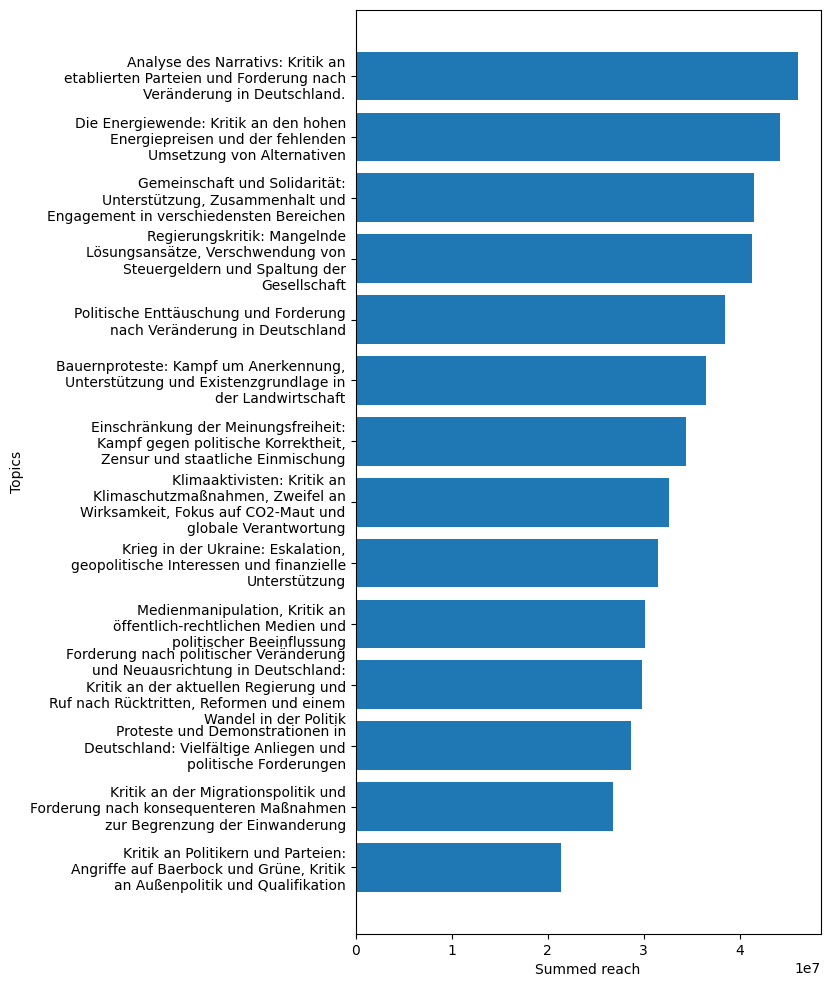

In [360]:

plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, summed_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[10:].remove("Analyse des Narrativs"),sorted_reach[10:])  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Summed reach')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

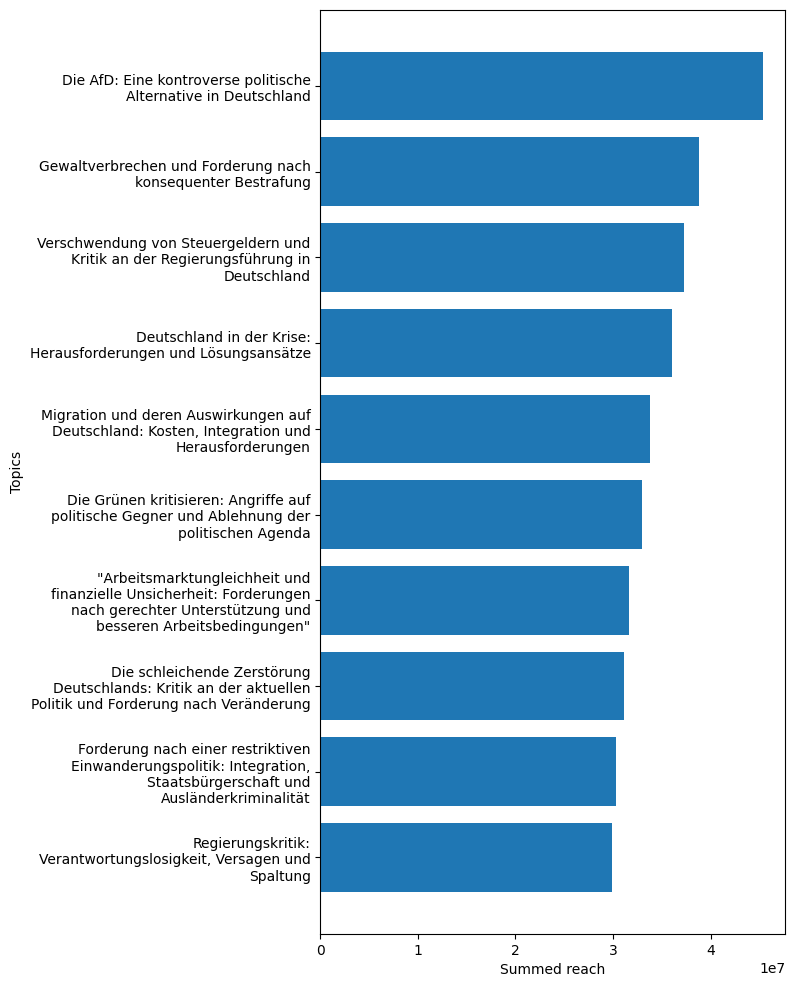

In [380]:
plt.figure(figsize=(6, 12))  # Adjust figure size as needed
wrapped_titles = [textwrap.fill(title, width=40) for title in topic_title]
sorted_data = sorted(zip(wrapped_titles, summed_reach), key=lambda x: x[1], reverse=True)
sorted_titles, sorted_reach = zip(*sorted_data)

plt.barh(sorted_titles[:10],sorted_reach[:10])  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Summed reach')
plt.ylabel('Topics')
#plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

In [ ]:
plt.bar(summed_reach, topic_title)

### Example week by week evaluation

In [394]:
topic_title

['Die AfD: Eine kontroverse politische Alternative in Deutschland',
 'Regierungskritik: Verantwortungslosigkeit, Versagen und Spaltung',
 'Die Generationen-Spaltung: Konsumorientierte Verschwendung vs. alternative Perspektiven',
 'Identität, Politik und gesellschaftlicher Wandel: Herausforderungen und Chancen in Deutschland',
 'Steuererhöhungen, Preisexplosionen und Belastungen für Bürger: Kritik an der Regierungspolitik und Forderung nach Entlastung',
 'Solidarität und Dankbarkeit: Gemeinschaft stärken, Unterstützung verschiedener Anliegen, positiver Zusammenhalt',
 'Forderung nach politischer Veränderung und Rücktritten zur Wahrung deutscher Interessen und Freiheit',
 'Migration und deren Auswirkungen auf Deutschland: Kosten, Integration und Herausforderungen',
 'Kritik an der deutschen Migrationspolitik: Gewaltkriminalität, Abschiebungen, Ungleichbehandlung und fehlende Argumente',
 'Unzufriedenheit mit der politischen Situation und der Regierung in Deutschland: Frustration, Vertrau

In [396]:
word= "Migration"
filtered_indices = [index for index, title in enumerate(topic_title) if word in title]

# Display the filtered titles along with their indices
li_cl=[]
for index in filtered_indices:
    print(f"Index: {index}, Title: {topic_title[index]}")
    li_cl.append(index)
filtered_df = df_cm[df_cm['cluster'].isin(li_cl)]

Index: 7, Title: Migration und deren Auswirkungen auf Deutschland: Kosten, Integration und Herausforderungen
Index: 8, Title: Kritik an der deutschen Migrationspolitik: Gewaltkriminalität, Abschiebungen, Ungleichbehandlung und fehlende Argumente


In [400]:
df_cm

,core_message,cluster,video_id,video_playcount,topic_title,video_timestamp
0,Streik am 08.0 in Deutschland - größter Streik...,32,7320578484609256736,6522042,Protestbewegungen und politische Unzufriedenhe...,1704455008
1,"- Züge, Bauern, LKW-Fahrer und Gastronomen bet...",47,7320578484609256736,6522042,Bauernproteste: Wut gegen die Bundesregierung ...,1704455008
2,- Unzufriedenheit mit politischer Lage und Geh...,9,7320578484609256736,6522042,Unzufriedenheit mit der politischen Situation ...,1704455008
3,falls sie in einem Land leben in dem sie für d...,35,7259813032321092891,6056046,Die schleichende Zerstörung Deutschlands: Krit...,1690306946
4,- Bürgergeld oder Grundeinkommen? Keins von be...,31,7317232563129552161,5817725,"Rentenproblematik in Deutschland: Altersarmut,...",1703675984
...,...,...,...,...,...,...
4730,- Erdogan bezeichnet Israel als Terrorstaat un...,38,7302847678910680353,500,Herausforderungen im Umgang mit Extremismus: I...,1700326732
4731,"- Erdogan bekräftigt, dass die Hamas keine Ter...",38,7302847678910680353,500,Herausforderungen im Umgang mit Extremismus: I...,1700326732
4732,- Erdogan fordert Anklage gegen Israel vor dem...,39,7302847678910680353,500,Kritik an Missbrauch von Gesetzen und Behörden...,1700326732
4733,du kennst die deutsche Außenministerin oder An...,34,7288696383404641568,420,Inkompetente Regierungsführung: Fehlende Kompe...,1697031876


In [404]:
word= "Grün"
filtered_videos = [index for index, title in enumerate(df_cm["core_message"]) if word in title]

filtered_df = df_cm[df_cm.index.isin(filtered_videos)]

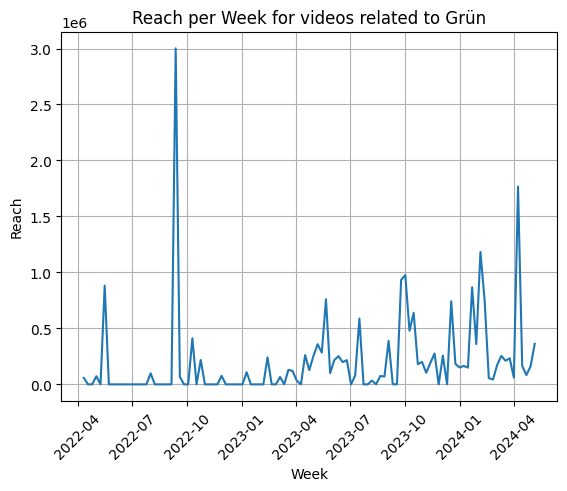

In [405]:

# Convert timestamps to datetime objects
dates = pd.to_datetime(filtered_df["video_timestamp"], unit='s')
reach = filtered_df["video_playcount"]

# Create a DataFrame with dates and reach values
data = pd.DataFrame({'Date': dates, 'Reach': reach})

# Group data by week and sum reach values
weekly_reach = data.resample('W-Mon', on='Date').sum()

# Plot the reach per week
plt.plot(weekly_reach.index, weekly_reach['Reach'])
plt.xlabel('Week')
plt.ylabel('Reach')
plt.title('Reach per Week for videos related to '+ word)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Overall reach per week 

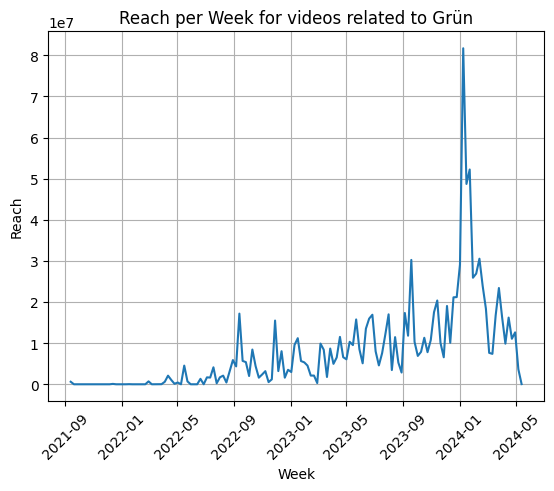

In [406]:
# Convert timestamps to datetime objects
dates = pd.to_datetime(df_cm["video_timestamp"], unit='s')
reach = df_cm["video_playcount"]

# Create a DataFrame with dates and reach values
data = pd.DataFrame({'Date': dates, 'Reach': reach})

# Group data by week and sum reach values
weekly_reach = data.resample('W-Mon', on='Date').sum()

# Plot the reach per week
plt.plot(weekly_reach.index, weekly_reach['Reach'])
plt.xlabel('Week')
plt.ylabel('Reach')
plt.title('Overall reach per week')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Topic covered this year per week 

In [412]:
df_cm.topic_title[:10]

0    Protestbewegungen und politische Unzufriedenhe...
1    Bauernproteste: Wut gegen die Bundesregierung ...
2    Unzufriedenheit mit der politischen Situation ...
3    Die schleichende Zerstörung Deutschlands: Krit...
4    Rentenproblematik in Deutschland: Altersarmut,...
5    "Kritik am politischen Establishment und Forde...
6    Forderung nach einer restriktiven Einwanderung...
7    Die Grünen kritisieren: Angriffe auf politisch...
8    Deutschland in der Krise: Herausforderungen un...
9    Die schleichende Zerstörung Deutschlands: Krit...
Name: topic_title, dtype: object

In [424]:
tr="Grün"
group_topics(tr)

'Grüne'

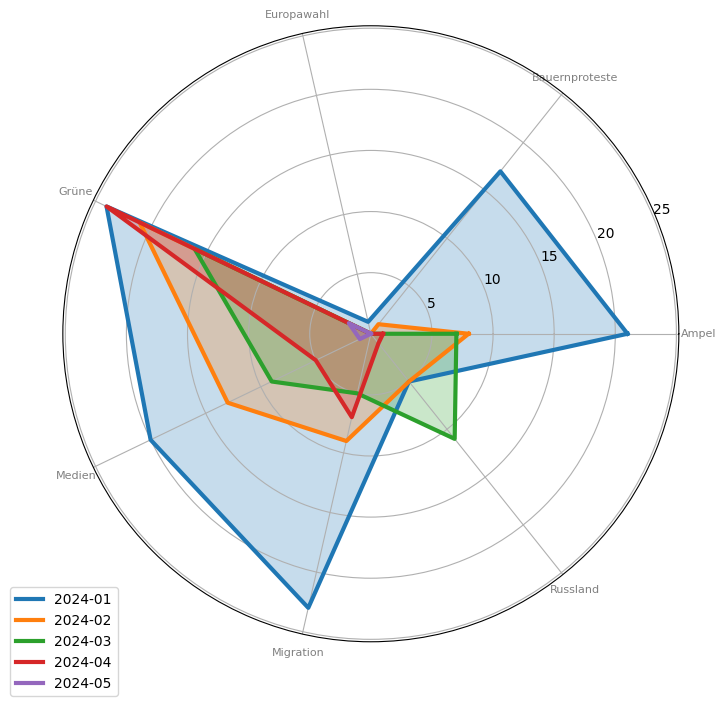

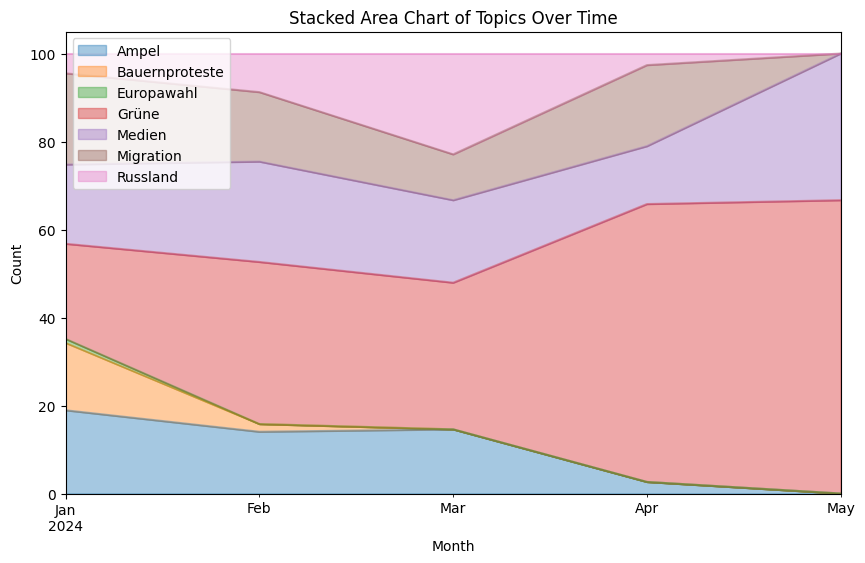

In [422]:
# Grouping function
def group_topics(topic):
    topic = topic.lower()
    if 'migration' in topic:
        return 'Migration'
    elif 'grün' in topic:
        return 'Grüne'
    elif 'ampel' in topic:
        return 'Ampel'
    elif 'europawahl' in topic:
        return 'Europawahl'
    elif 'medien' in topic:
        return 'Medien'
    elif 'russland' in topic:
        return 'Russland'
    elif 'bauernprotest' in topic:
        return 'Bauernproteste'
    else:
        return 'Other'

# Apply grouping
df_cm['grouped_topic'] = df_cm['core_message'].apply(group_topics)

# Convert timestamp to datetime
df_cm['video_timestamp'] = pd.to_datetime(df_cm['video_timestamp'], unit='s')

# Extract month and year
df_cm['year_month'] = df_cm['video_timestamp'].dt.to_period('M')

df_cm_filtered = df_cm[df_cm['video_timestamp'].dt.year >= 2024]
df_cm_filtered = df_cm_filtered[df_cm_filtered['grouped_topic'] != 'Other']
# Aggregate data by month and topic
monthly_data = df_cm_filtered.groupby(['year_month', 'grouped_topic']).size().unstack().fillna(0)

# Radar Chart
categories = monthly_data.columns
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each month
months = monthly_data.index
for month in months:
    values = monthly_data.loc[month].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=3, linestyle='solid', label=str(month))
    ax.fill(angles, values, alpha=0.25)  # Fill with shading

# Add labels
plt.xticks(angles[:-1], categories, color='grey', size=8)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.show()
# Normalize the data to 100% for each month
monthly_data_percentage = monthly_data.div(monthly_data.sum(axis=1), axis=0) * 100

# Stacked Area Chart
monthly_data_percentage.plot.area(figsize=(10, 6), alpha=0.4)
plt.title('Stacked Area Chart of Topics Over Time')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend(loc='upper left')
plt.show()


# Data analyses

### Count hashtags by pure frequency

In [77]:
from collections import Counter

def return_hashtags(document):
    # Extract hashtags from descriptions
    hashtags = [word.lower() for description in document for word in description.split() if word.startswith("#")]

    # Count the frequency of each hashtag
    hashtag_counts = Counter(hashtags)

    # Sort hashtags by frequency
    sorted_hashtags = sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_hashtags_array=np.array([list(pair) for pair in sorted_hashtags])
    return sorted_hashtags_array

docs_non_right=docs[result!="right"]

sorted_hashtags=return_hashtags(docs_clean)
sorted_hashtags_nr=return_hashtags(docs_non_right)


In [112]:
def filter_common_hashtags(array1, array2, threshold=10):
    # Extract hashtags and counts from the arrays
    hashtags1, counts1 = array1[:, 0], array1[:, 1].astype(int)
    hashtags2, counts2 = array2[:, 0], array2[:, 1].astype(int)
    
    # Apply threshold to array2
    array2 = array2[counts2 > threshold]
    hashtags2, counts2 = array2[:, 0], array2[:, 1].astype(int)
    
    # Find common hashtags
    common_hashtags = set(hashtags1) & set(hashtags2)
    
    # Filter array1 to remove entries with common hashtags
    filtered_array1 = array1[~np.isin(array1[:, 0], list(common_hashtags))]
    
    return filtered_array1

In [114]:
sorted_hashtags_filtered= filter_common_hashtags(sorted_hashtags, sorted_hashtags_nr)

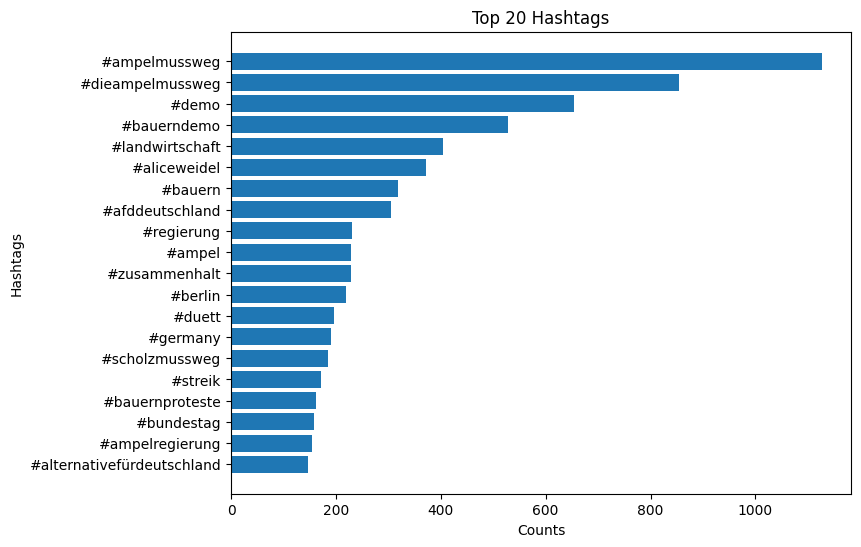

In [118]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(sorted_hashtags_filtered[:20,0],sorted_hashtags_filtered[:20,1].astype(int))  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Counts')
plt.ylabel('Hashtags')
plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

### Count hashtags per week of video publication

In [195]:

def most_trending_hashtag_per_week(df, date_column, hashtags_column):
    """
    Display the most trending hashtag per week based on the date of video publication.

    Args:
    - df (pandas.DataFrame): DataFrame containing the data.
    - date_column (str): Name of the column containing the date of video publication.
    - hashtags_column (str): Name of the column containing hashtags.

    Returns:
    - pandas.DataFrame: DataFrame containing the most trending hashtags per week with the most reach.
    """

    # Convert date of video publication to year and week number
    df['Week'] = pd.to_datetime(df[date_column], format='%Y-%m-%d %H:%M:%S', errors='coerce').fillna(
        pd.to_datetime(df[date_column], format='%Y-%m-%dT%H:%M:%S', errors='coerce')).dt.strftime('%Y-%U')

    # Create a dictionary to store the count of hashtags for each year and week
    weekly_hashtags_count = defaultdict(lambda: defaultdict(int))

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        year_week = row['Week']
        hashtags = re.findall(r'#\w+', str(row[hashtags_column]))
        for hashtag in hashtags:
            weekly_hashtags_count[year_week][hashtag] += 1

    # Initialize an empty list to store the results
    results = []

    # Iterate over each year and week
    for year_week, hashtags_count in weekly_hashtags_count.items():
        # Find the top 3 hashtags for the year and week with the most reach
        top_hashtags = sorted(hashtags_count, key=hashtags_count.get, reverse=True)[:3]
        for hashtag in top_hashtags:
            results.append({'Year_Week': year_week,
                            'Hashtag': hashtag,
                            'Count': hashtags_count[hashtag]})

    # Convert the list of results to a DataFrame
    most_trending_per_week = pd.DataFrame(results)
    most_trending_per_week = most_trending_per_week.sort_values(by='Year_Week')

    return most_trending_per_week

In [196]:
most_trending_per_week = most_trending_hashtag_per_week(df_filtered, "video_timestamp", "video_description")
print(most_trending_per_week)

   Year_Week                 Hashtag  Count
78   2023-26       #ahrtalhochwasser      1
79   2023-26  #wasdenktihrwerihrseit      1
80   2023-26         #politikerlügen      1
86   2023-28                  #viral      1
85   2023-28    #nationalbewusstsein      1
..       ...                     ...    ...
51   2024-17                    #afd     11
53   2024-17         #afddeutschland      6
88   2024-18             #düsseldorf      1
87   2024-18                 #weidel      1
89   2024-18            #kämpferherz      1

[90 rows x 3 columns]


### Count hashtags by cummulative reach

In [165]:
df_filtered=df[:][result=="right"]
df_filtered_nr=df[:][result!="right"]

In [166]:
from collections import defaultdict
import re

def calculate_cumulative_reach_from_description(df, description_column, reach_column):
    """
    Calculate the cumulative reach per hashtag found in the description column of the DataFrame.

    Args:
    - df (pandas.DataFrame): DataFrame containing the data.
    - description_column (str): Name of the column containing descriptions.
    - reach_column (str): Name of the column containing reach/count.

    Returns:
    - dict: Dictionary containing each hashtag and its cumulative reach.
    - int: Total cumulative reach.
    """

    # Create a dictionary to store cumulative reach for each hashtag
    hashtags_reach = defaultdict(int)

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows():
        description = row[description_column]
        reach = row[reach_column]

        # Find all hashtags in the description using regex
        hashtags = re.findall(r'#\w+', str(description))
        for hashtag in hashtags:
            hashtags_reach[hashtag] += reach

    # Sort the dictionary by reach in descending order
    sorted_hashtags_reach = np.array(sorted(hashtags_reach.items(), key=lambda x: x[1], reverse=True))
    sorted_hashtags_reach[:,1]=sorted_hashtags_reach[:,1].astype(int)

    return sorted_hashtags_reach


In [167]:
hashtags_reach = calculate_cumulative_reach_from_description(df_filtered, "video_description", "video_playcount")
hashtags_reach_nr = calculate_cumulative_reach_from_description(df_filtered_nr, "video_description", "video_playcount")

In [168]:
sorted_hashtags_filtered= filter_common_hashtags(hashtags_reach, hashtags_reach_nr, threshold=1000000)

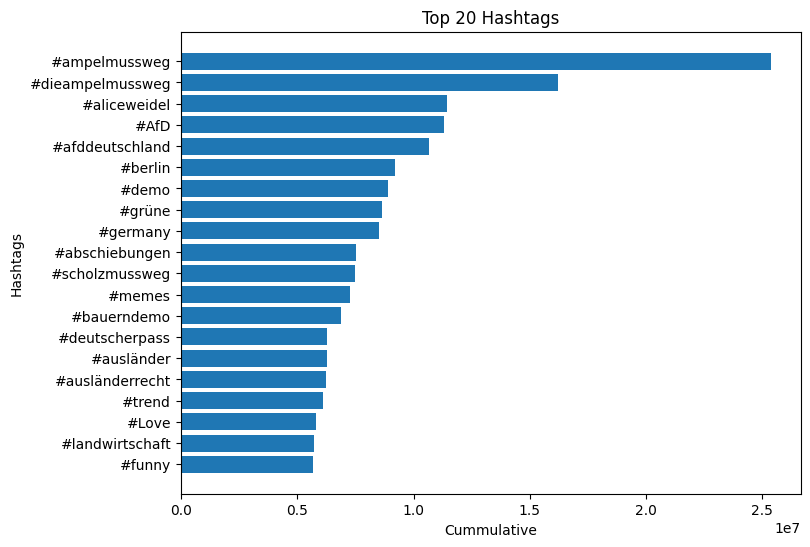

In [173]:
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.barh(sorted_hashtags_filtered_count[:20,0],sorted_hashtags_filtered_count[:20,1].astype(int))  # Use barh for horizontal bar chart

# Adding labels and title
plt.xlabel('Cummulative')
plt.ylabel('Hashtags')
plt.title('Top 20 Hashtags')

# Display the plot
plt.gca().invert_yaxis()  # Invert y-axis to display the highest count at the top
plt.show()

Add Cluster labels to dataframe

Remove documents that are not in a cluster

In [212]:
df_clean = df_clean.query("cluster != -1")

Print numbers of cluster entities

In [214]:
print(df_clean.cluster.value_counts())

cluster
99     55
194    32
180    21
176    20
106    19
       ..
37      3
83      3
142     3
66      3
128     3
Name: count, Length: 218, dtype: int64


In [215]:
# get rows with cluster id 0 and show urls
df_clean.query("cluster == 0")

,video_id,video_timestamp,video_duration,video_locationcreated,video_diggcount,video_description,author_username,suggested_words,video_playcount,Unnamed: 0,...,author_followercount,author_followingcount,author_heartcount,author_videocount,author_diggcount,author_verified,url,english_transcript,german_transcript,cluster
2899,7344779279537851680,2024-03-10 16:54:54,66,DE,105531,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,afd eines lers 🙏🏾leroyen sch twitch leroyen le...,1375426,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2923,7331423849877097760,2024-02-03 17:09:01,83,DE,11110,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube leroyen die ergibt sinn💀😭 leroy2real k...,153302,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2924,7329938788854140192,2024-01-30 17:06:13,95,DE,42028,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube leroyen team sein leroy2real twitch ta...,475668,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2975,7333653936831843616,2024-02-09 17:22:52,62,DE,22033,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,twitch 🙏🏾leroyen ergibt keinen die sinn youtub...,303560,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3023,7330676559218576672,2024-02-01 16:49:07,70,DE,17598,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,youtube gehören?!😭💀 leroyen ren geh afd leroy2...,238383,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3434,7329568047935556897,2024-01-29 17:07:33,68,DE,83651,Twitch & YouTube : Leroy2Real 🙏🏾#leroyen,leroytoreal,wechseln leroyen leroy2real twitch sp unbeding...,1133436,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Create a Wordcloud

In [221]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re
import string
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pechenovae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pechenovae/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [222]:
def preprocess_text(text):
    # Checking if the input is a string
    if isinstance(text, str):
        # Converting to lowercase
        text = text.lower()
        # Removing punctuation
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        # Removing non-alphabetic characters
        text = re.sub('\W', ' ', text)
        # Removing long strings of whitespace
        text = re.sub('\s+', ' ', text).strip()
        # Removing äh
        text = re.sub('äh', ' ', text).strip()
        # Removing mal
        text = re.sub('mal', ' ', text).strip()
        # Removing ja
        text = re.sub('ja', ' ', text).strip()
        # Tokenizing the text
        words = word_tokenize(text)
        # Removing stopwords
        stop_words = set(stopwords.words('german'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)
    else:
        # Asking to return an empty string if the input is not a string
        return ''

In [223]:
cleaned_docs = [preprocess_text(docs[i]) for i in range(len(docs))]

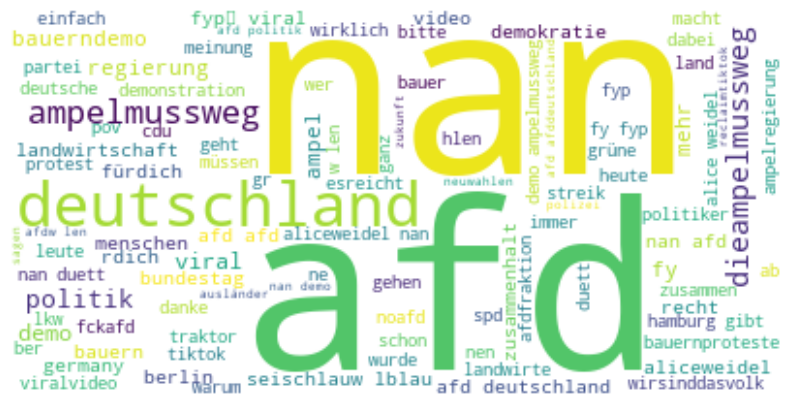

In [224]:
wordcloud_signature = WordCloud(background_color = 'white', max_words = 100).generate(' '.join(cleaned_docs))

# Displaying the word cloud for the signatures
plt.figure(figsize = (10, 10))
plt.imshow(wordcloud_signature, interpolation = 'bilinear')
plt.axis('off')
plt.show()